## Anomaly Detection - LSTM (Time series Data)

In this experiment, we have used the Numenta Anomaly Benchmark (NAB) data set that is publicly available on Kaggle.


It comprises temperature sensor data of an internal component of a large industrial machine. This dataset contains anomalies including the shutdown of the machine, catastrophic failure of the machine etc. 

### Implementation of Anomaly Detection

In [1]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

In [2]:
#Reading file from local system
df = pd.read_csv("ambient_temperature_system_failure.csv")

In [3]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


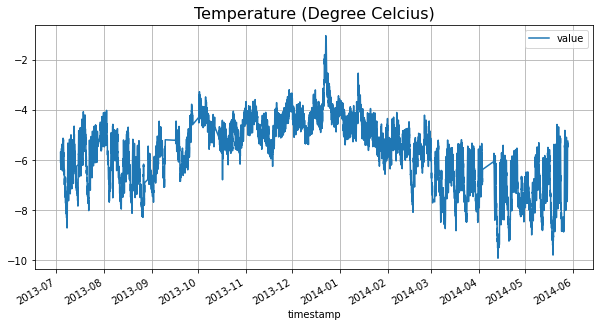

In [5]:
#Visualizing Data

figsize=(10,5)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value', figsize=figsize);
plt.title('Temperature (Degree Celcius)', fontsize=16);
plt.grid();
plt.show();

To check the stability of temperature during days and nights of weekdays and weekends we are going to preprocess our data accordingly. First, we will specify hours, then days, then weekdays and nights. Finally, we will visualize the temperature during these time-periods using a histogram. 

In [7]:
#Formating the data into required format
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [8]:
# Anomaly estimated population
outliers_fraction = 0.01

In [9]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

df['categories'] = df['WeekDay']*2 + df['daylight']
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

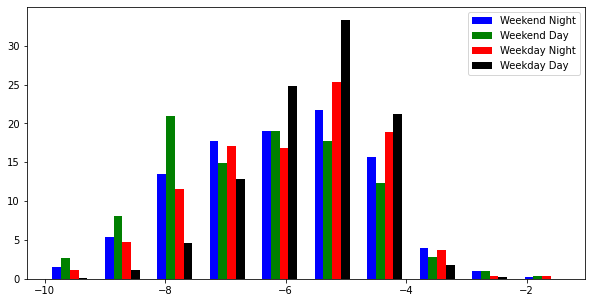

In [10]:
#Visualizing the formatted data
figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Day')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Day')
plt.legend()
plt.show()

The above histogram shows that the temperature is comparatively more stable during Week Days in the daylights. Now, we will preprocess our dataset for training the LSTM recurrent neural network. For this purpose, first, we will take the required columns from the dataset and scale it using Standard Scaler. 

In [11]:
#Preparing the data for LSTM model
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In the next step, we will define and initialize the required parameters and define the training and the test data set. We are going to learn from 50 previous values and we predict through the LSTM model just the one next value.

In [12]:
#Important parameters and training/Test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1


In [13]:
#Training data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

#Test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

The below unrolling function will create a sequence of 50 previous data points for each of the training and test data point.

In [14]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [15]:
#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [16]:
#Shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


Next step, we will define and add layers to the LSTM Recurrent Neural Network one-by-one.

In [20]:
#Building the model
model = Sequential()

model.add(LSTM( 50, input_dim=x_train.shape[-1], return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))


compilation time : 0.015629053115844727


In [24]:
model.fit(x_train, y_train, batch_size=3028, epochs=50, validation_split=0.1)

Epoch 1/50
2/2 [==============================] - 9s 1s/step - loss: 0.5849 - val_loss: 0.7733
Epoch 2/50
2/2 [==============================] - 2s 935ms/step - loss: 0.1877 - val_loss: 0.3521
Epoch 3/50
2/2 [==============================] - 2s 887ms/step - loss: 0.1191 - val_loss: 0.2283
Epoch 4/50
2/2 [==============================] - 2s 892ms/step - loss: 0.1344 - val_loss: 0.2232
Epoch 5/50
2/2 [==============================] - 2s 999ms/step - loss: 0.1189 - val_loss: 0.1981
Epoch 6/50
2/2 [==============================] - 2s 820ms/step - loss: 0.0907 - val_loss: 0.1883
Epoch 7/50
2/2 [==============================] - 2s 831ms/step - loss: 0.0849 - val_loss: 0.1789
Epoch 8/50
2/2 [==============================] - 2s 839ms/step - loss: 0.0833 - val_loss: 0.1730
Epoch 9/50
2/2 [==============================] - 2s 832ms/step - loss: 0.0826 - val_loss: 0.1579
Epoch 10/50
2/2 [==============================] - 2s 1s/step - loss: 0.0893 - val_loss: 0.1483
Epoch 11/50
2/2 [========

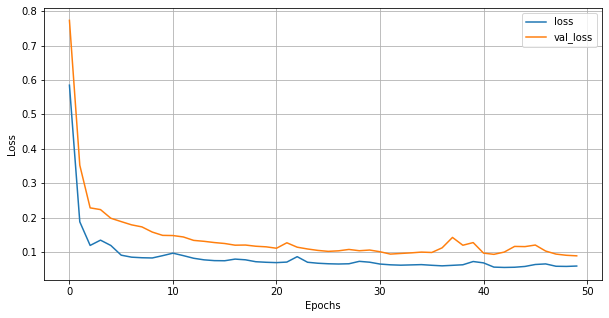

In [31]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
p1 = plt.plot(model.history.history['loss'], label = 'loss')
p2 = plt.plot(model.history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

Now, we will execute the below code snippet to better understand the difference between the original data and the predicted data through the visualization.

In [32]:
#creating the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [34]:
ratio[0:5]

[0.8896816697674521,
 1.0420512753116,
 0.6014710241528614,
 0.472981429859197,
 0.49314192997599937]

In [35]:
diff[0:5]

[0.4185129971254449,
 0.7235656363810434,
 0.5304822601999548,
 0.5002283278147528,
 0.5888138186970888]

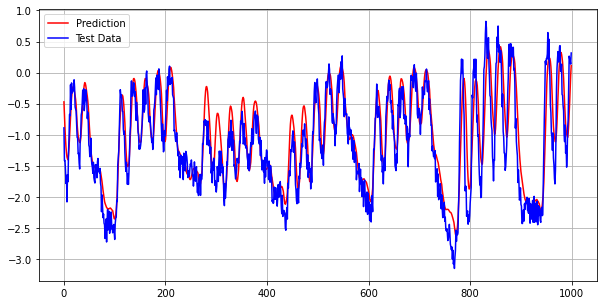

In [36]:
#Plotting the prediction and the reality (for the test data)
plt.figure(figsize = (10, 5))
plt.plot(p,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

Now, in the next step, we are going to find the anomalies. The most distant predicted values are considered as anomalies. Using the below code snippet, we will find the anomalies in the data.

In [44]:
#Pick the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())
print(len(df['anomaly27']))

0    7257
1      10
Name: anomaly27, dtype: int64
7267


C:\Users\lalhi\AppData\Local\Temp/ipykernel_7484/3854664660.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df['anomaly27'] = complement.append(test, ignore_index='True')


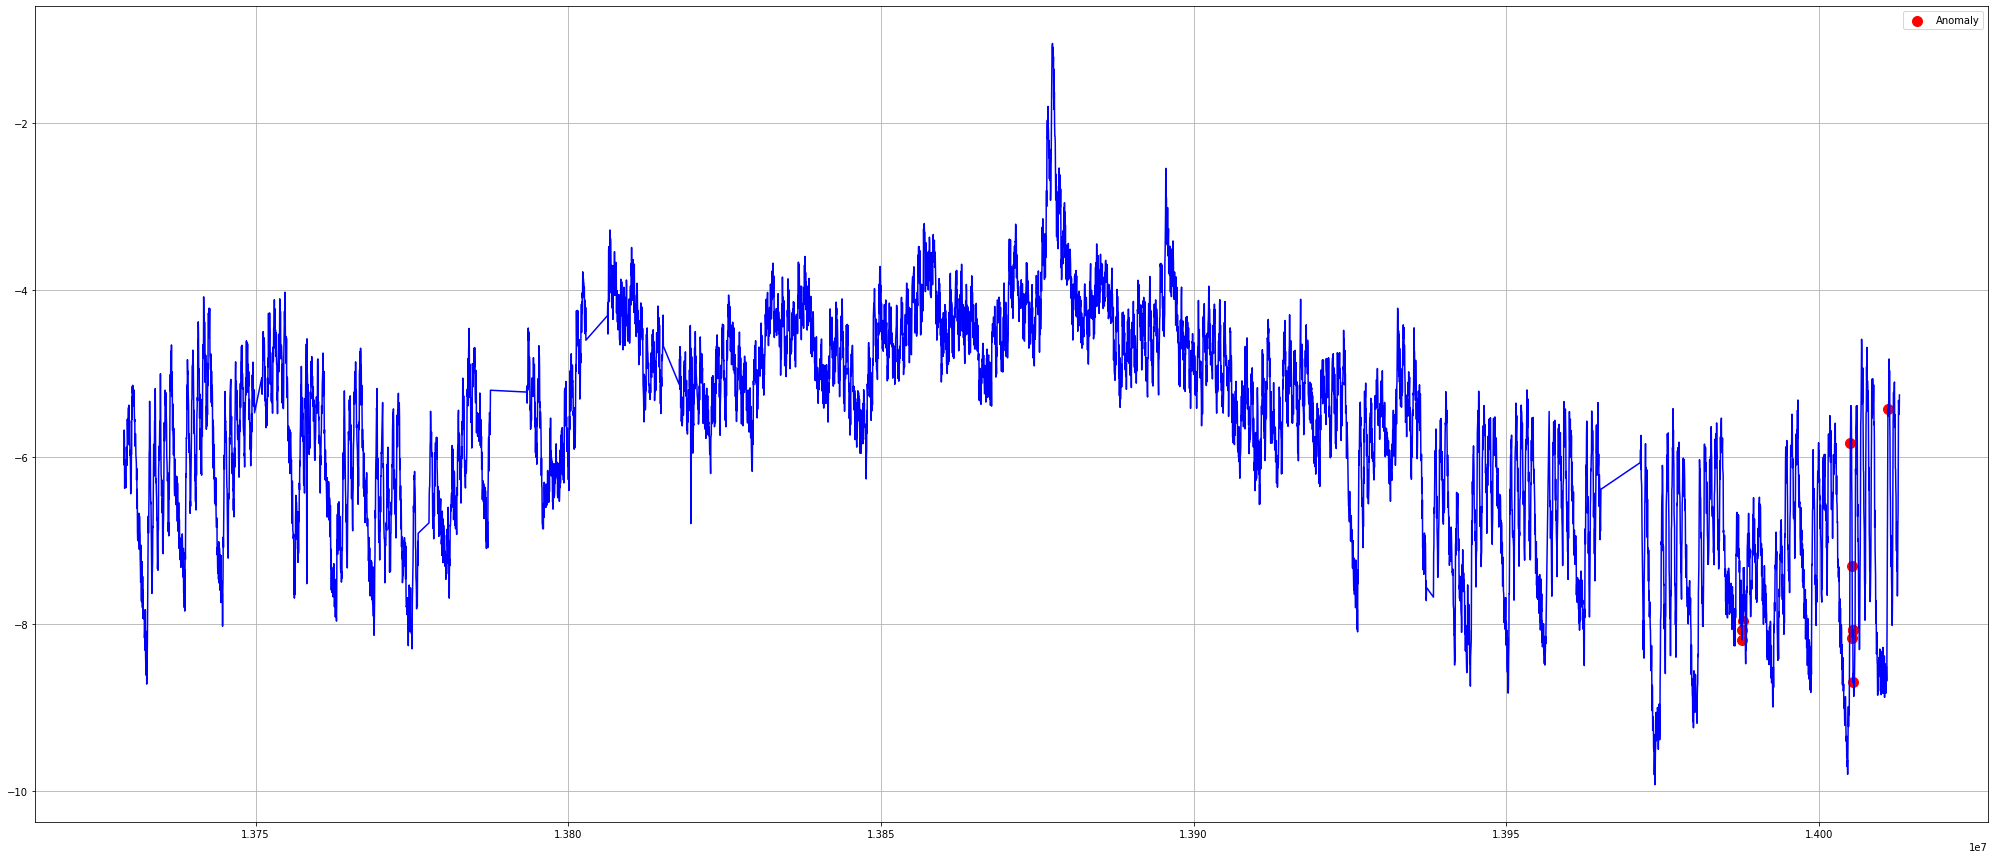

In [52]:
#Visualizing anomalies (Red Dots)
plt.figure(figsize=(35,15))
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(df['time_epoch'], df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red', s = 100 ,label = 'Anomaly')
# plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.grid()
plt.legend()

The anomalies are visualized as red points. All the above steps can be repeated multiple times to visualize the anomalies by tuning the hyperparameters. If we find the same visualization at the end, then we can end-up with these anomalies. 